In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
import seaborn as sns
from joblib import Parallel, delayed

import torch
import torch.nn as nn

In [2]:
def online_sample_from_task_sequence(t, N=20, d=2):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-3, -3])    
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.relu(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
def create_dataset(sequence, labels, look_back=1):
    X, Y = [], []
    for i in range(len(sequence)-look_back-1):
        temp = sequence[i:(i+look_back+1), :]
        X.append(temp)
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

In [5]:
N = 10
T = 500
lookback = 25

In [6]:
X_train = np.empty((0, 2))
Y_train = np.empty((0,))

for t in range(1, T+1):
    x, y = online_sample_from_task_sequence(t, N)
    if y < 0: y = 0

    X_train = np.concatenate((X_train, x.reshape(1, 2)), axis=0)
    Y_train = np.append(Y_train, y)

In [7]:
X, Y = create_dataset(X_train, Y_train, look_back=lookback)
X = torch.Tensor(X)
Y = torch.Tensor(Y[:, None])

In [17]:
rnn = RNN(2, 4, 2)

In [18]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005

def train(x, y):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(x.size()[0]):
        output, hidden = rnn(x[i][None, :], hidden)
    loss = criterion(output, y.long())
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [19]:
n_iters = 100000
current_loss = 0
check_every = 1000
all_losses = []
for iter in range(1, n_iters + 1):
    i = np.random.randint(0, len(X) - 1)
    output, loss = train(X[i], Y[i])
    current_loss += loss

    if iter % check_every == 0:
        all_losses.append(current_loss / check_every)
        print("loss at iteration {} : {:4f}".format(iter, current_loss / check_every))
        current_loss = 0

loss at iteration 1000 : 0.648161
loss at iteration 2000 : 0.617460
loss at iteration 3000 : 0.610779
loss at iteration 4000 : 0.617184
loss at iteration 5000 : 0.602574
loss at iteration 6000 : 0.607007
loss at iteration 7000 : 0.598179
loss at iteration 8000 : 0.597028
loss at iteration 9000 : 0.580122
loss at iteration 10000 : 0.577936
loss at iteration 11000 : 0.567842
loss at iteration 12000 : 0.533150
loss at iteration 13000 : 0.534136
loss at iteration 14000 : 0.512900
loss at iteration 15000 : 0.506880
loss at iteration 16000 : 0.496065
loss at iteration 17000 : 0.486285
loss at iteration 18000 : 0.480331
loss at iteration 19000 : 0.479498
loss at iteration 20000 : 0.467307
loss at iteration 21000 : 0.461414
loss at iteration 22000 : 0.459520
loss at iteration 23000 : 0.455633
loss at iteration 24000 : 0.455555
loss at iteration 25000 : 0.446721
loss at iteration 26000 : 0.435812
loss at iteration 27000 : 0.432361
loss at iteration 28000 : 0.439764
loss at iteration 29000 : 0.4

### Evaluate

In [20]:
num_reps = 100

In [21]:
def predict(x):
    hidden = rnn.initHidden()
    for i in range(x.size()[0]):
        output, hidden = rnn(x[i][None, :], hidden)
    return np.argmax(output.detach().numpy())

In [22]:
predictions = np.zeros((num_reps, T-1))
groundtruth = np.zeros((num_reps, T-1))
accuracy_list = []
for rep in range(num_reps):
    X_test = np.empty((0, 2))
    Y_test = np.empty((0,))

    for t in range(T+1, 2*T+1):
        x, y = online_sample_from_task_sequence(t, N)
        if y < 0: y = 0

        X_test = np.concatenate((X_test, x.reshape(1, 2)), axis=0)
        Y_test = np.append(Y_test, y)
    
    X_test = np.concatenate((X_train, X_test))
    Y_test = np.concatenate((Y_test, Y_test)) 

    X_t, Y_t = create_dataset(X_test[T-lookback:], Y_test[T-lookback:], look_back=lookback)
    X_t = torch.Tensor(X_t)

    Y_pred = []
    for i in range(len(X_t)):
        Y_pred.append(predict(X_t[i]))
    Y_pred = np.array(Y_pred)
    predictions[rep, :] = Y_pred
    groundtruth[rep, :] = Y_t

    accuracy_list.append(np.mean(Y_pred == Y_t))

In [23]:
mean_error = np.mean(predictions != groundtruth, axis=0)

In [24]:
print("accuracy : {:4f} +/- {:4f}".format(np.mean(accuracy_list), np.std(accuracy_list)))

accuracy : 0.892365 +/- 0.013634


In [25]:
std_error = np.std(predictions != groundtruth, axis=0)
ci = std_error * 1.96/np.sqrt(num_reps)

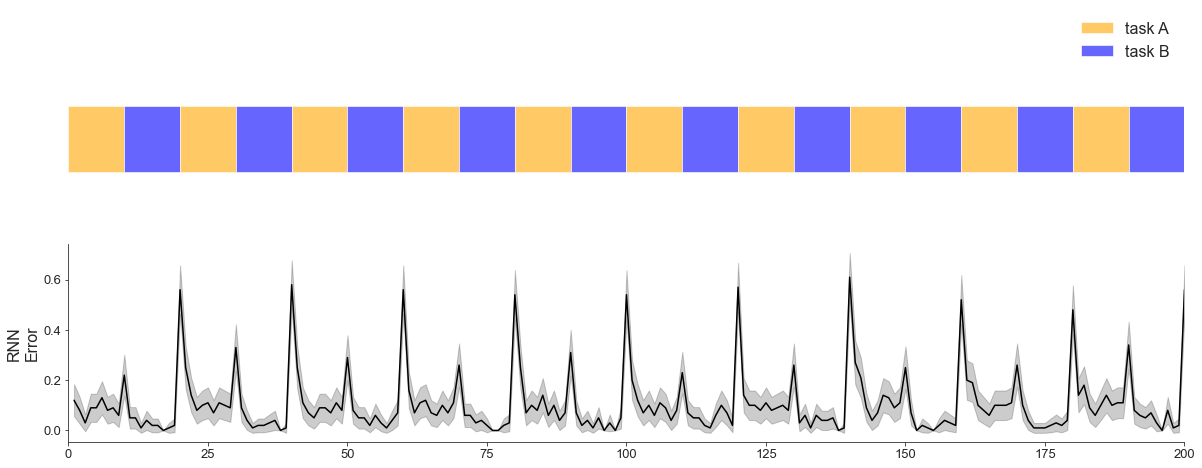

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
ax = axes[0]
end = 200+1
xlocs = np.arange(0, end, N)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(np.arange(1, end), mean_error[:end-1], c='k')
x = np.arange(1, end)
y = mean_error[:end-1]
c = ci[:end-1]
plt.fill_between(x, y-c, y+c, alpha=0.2, color='k')
ax.set_ylabel("RNN" + "\n" + "Error", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
plt.show()
